In [632]:
%gui qt5

In [633]:
#import thermosteam as tmo
from thermosteam import functional as fn #useful functions for building chemicals
import biosteam as bst

In [705]:
## Define common chemicals 
chemicals = bst.Chemicals(['9003-53-6',
                           'Water', 
                           '544-63-8', 
                           '57-10-3', 
                           '373-49-9', 
                           '57-11-4',
                           '112-80-1',
                           '60-33-3'], cache = True)

(polystyrene, 
 Water, 
 myristic, 
 palmitic, 
 palmitoleic, 
 steric, 
 oleic, 
 linoleic)= chemicals

In [707]:
#define the phase of these chemicals
polystyrene.at_state(phase='s')
Water.at_state(phase='l')
myristic.at_state(phase = 'l')
palmitic.at_state(phase = 'l')
palmitoleic.at_state(phase = '1')
steric.at_state(phase = 'l')
linoleic.at_state(phase = 'l')

In [698]:
## defining new chemicals (a lil functiony boi)
# may need to use this later 
def create_new_chemical(ID, phase='s', **constants):
    solid= bst.Chemical.blank(ID, phase=phase, **constants)
    chemicals.append(solid)
    return solid

#yellowGrease = create_new_chemical('yellowGrease', MW = 282.)
#yellowGrease.at_state(phase='l')

#C : 14 Myristic 1.0%
#C : 16 Palmitic 16.1%
#C : 16 : 1 Palmitoleic 1.0%
#C : 18 Steric 10.0%
#C : 18 : 1 Oleic 49.0%
#C : 18 : 2 Linoleic 18.0%
# https://www.valleyproteins.com/wp-content/uploads/2011-Stab-Yellow-Grease-06.30.10.pdf


TypeError: 'CompiledChemicals' object is read-only

In [637]:
##Fill missing properties 

#polystyrene getting volume from rhe density in kg/m3
V=fn.rho_to_V(rho= 45, MW=chemical.MW)
polystyrene.V.add_model(V, top_priority=True)

#water getting volume from the density in kg/m3
V=fn.rho_to_V(rho=1000, MW=chemical.MW)
Water.V.add_model(V, top_priority=True)





#for chemical in soluble_solids:
#    V = fn.rho_to_V(rho=1e5, MW=chemical.MW)
#    chemical.V.add_model(V, top_priority = True)

#for chemical in insoluble_solids:
#    V = fn.rho_to_V(rho= 1540, MW = chemical.MW) #confused about this choice of number tbh
#    chemical.V.add_model(V, top_priority= True)


0.00028199999999999997

In [638]:
for chemical in chemicals:
    chemical.default()
#    print(chemical)
    

chemicals.compile()

chemicals.set_synonym('Water', 'H2O')
chemicals.set_synonym('9003-53-6', 'polystyrene')

bst.settings.set_thermo(chemicals)

In [639]:
#define process settings

bst.CE = 607.5 #2019 chemical plant cost index
bst.PowerUtility.price = .065 #power utility options (USD/kJ)

from biosteam import HeatUtility
#Heat/Cooling Utilities

HeatUtility = bst.HeatUtility
# Steam is produced on-site by a boiler,
# so make it the only available heating agent

HeatUtility.default_heating_agents()
steam_utility = HeatUtility.get_agent('high_pressure_steam')
HeatUtility.heating_agents = [steam_utility]
steam_utility.heat_transfer_efficiency = 0.85

steam_utility.regeneration_price = 0.30626
steam_utility.T = 529.2
steam_utility.P = 44e5


#calculate utility requirement by calling it with a duty (kJ/hr) and entrance and exit temperature (K)




In [640]:



#price of regenerating the utility in USD/kmol
#cooling_water.regeneration_price

#change the temperature of cooling water
#cooling_water.T = 302

#heating agents
#hps = bst.HeatUtility.get_heating_agent('high_pressure_steam')

#ultrasound(1000,400,450) #need to figure out kJ/hr

In [641]:
#raw material price (USD/kg)
price = {'yellowGrease': .55,
         'polystyrene': 1.,
        'Water': .000353}

# waste corn oil ~= 3~4c per gallon 
# get the spreadsheet from julie that has these numbers
# yellow grease = 23c/lb


In [645]:
from biosteam import units
import numpy as np

#PRETREATMENT

bst.main_flowsheet.set_flowsheet('polystyrene_reaction_pretreatment')

#relative percentages of inputs (broken and idk why)
z_mass_mixture = chemicals.kwarray(
    dict(polystyrene = .2, yellowGrease = .8, Water = .02))

##define streams
#need to look into the stream documentation so that i know what i can put here
plastic_mix = bst.Stream('plastic_mix',
                        flow  = 333334 * z_mass_mixture,
                        units = 'kg/hr',
                        price = price['polystyrene']*z_mass_mixture[0]+
                        price['yellowGrease']*z_mass_mixture[2])

#buggy: for some reason the z_mass_mixture stores yellowGrease as index 2 even though it should be index 1

plastic_mix.price


1.0

In [695]:
#design a utility agent that operates as ultrasound??
transducer = bst.UtilityAgent(ID='transducer', 
                              flow=333334 * z_mass_mixture, 
                              phase='l', 
                              T=600., 
                              P= 50000000., 
                              T_limit = 600., 
                              heat_transfer_price = .065, 
                              heat_transfer_efficiency=.85)

ultrasound = bst.Unit(ID= 'ultrasound', ins=None, outs = ())

ultrasound.power_utility = 2000

#that didn't work. try again!
ultrasound_hifu = bst.HeatUtility(heat_transfer_efficiency=.85)
ultrasound_hifu.duty = 10000 #no idea what this should be yet
ultrasound_hifu.flow = 333334 * z_mass_mixture



#ultrasound_HX = bst.HXutility(ID = 'ultrasound', T = 773.15, V=.2*.7, rigorous=True)


In [696]:
##Unit Operations##

#Conveyor Belt
U101 = units.ConveyingBelt('U101', ins = plastic_mix)

#print(U101.outs)

#Shred the material
S101 = units.Shredder('S101', ins = U101-0)

#Pump the material
P101 = units.Pump('P101', ins = S101-0)

#Mix everything
M101 = units.Mixer('M101', ins = P101-0)

#Store in Tank
U102 = units.StorageTank('U102', ins = M101-0)

#Auger
U103 = units.ScrewFeeder('U103', ins = U102-0)
print(U103.outs)

#Pump
P102 = units.Pump('P102', ins= U103-0)

#M201 = units.Mixer('M201')
#T202 = units.StorageTank('T202', tau=4, vessel_material='Carbon steel')

#T101 = transducer('T101', ins = U103-0)
#H101 = units.HXutility('H101', ins= U103-0,  T=573.15)

H101 = bst.HXutility('ultrasound', ins = U103-0, outs = 'product', T = 773.15,rigorous=True)


#split the bottom fraction
U105 = units.Splitter('U105', ins = H101-0, outs = ('top', 'bot'), split = .5)

#pump
P103 = units.Pump('P103_Recirculation', ins = 'bot')

#incorporating the recirculation
(P103-0, U103-0)-H101


#pump
P104 = units.Pump('P104', ins = 'top')

#Design the binary distillator to replace the splitter
#D101 = units.BinaryDistillation('D101', ins = H101-0, LHK=('polystyrene', 'linAcid'), k=2)


#need to do condensing instead
H102 = units.HXutility('H102_cooledDown', ins = P104-0, T= 273.15)

#storage tank
U106 = units.StorageTank('U106', ins = H102-0, outs = 'done')

#H101.H_out
#H102.show()



#RIS notes
#outputs (what can u sell)
#- kerosene 
#- aromatics
#(generalize among jet fuel mixtures)


#assumptions
# what is cost breakdown from a selected input for 100m revenue
# can we even make 100m @ scale with 1 input? who r the players
# go back and iterate until viable combo of inputs and outputs at scale to justify 100m rev

# goal: stress test the business and find key assumptions/blind spots scaleup wise
# 1st pass will not be 100m revenue company. goal is to take assumptions we have and scale that to 100m with unit econ based on cogs
    # how much $$$ do we even have to spend to get that 100m
    # right now, what are your thoughts?
    # @future investors: "this is our business going fwd"


[<Stream: s986>]


RuntimeError: no chemicals to perform equilibrium

In [554]:
#from biosteam.units import HXprocess
#from biosteam import Stream, settings

#settings.set_thermo(['Water', 'Ethanol'])
#in_a = Stream('in_a', Ethanol=50, T=351.43, phase='g')
#in_b = Stream('in_b', Water=200)
#hx = HXprocess('hx', ins=(in_a, in_b), outs=('out_a', 'out_b'))
#hx.simulate()
#hx.show()
#hx.results()

Stream: s961 from <ScrewFeeder: U103> to <HXutility: ultrasound>
 phase: 'l', T: 298.15 K, P: 101325 Pa
 flow: 0


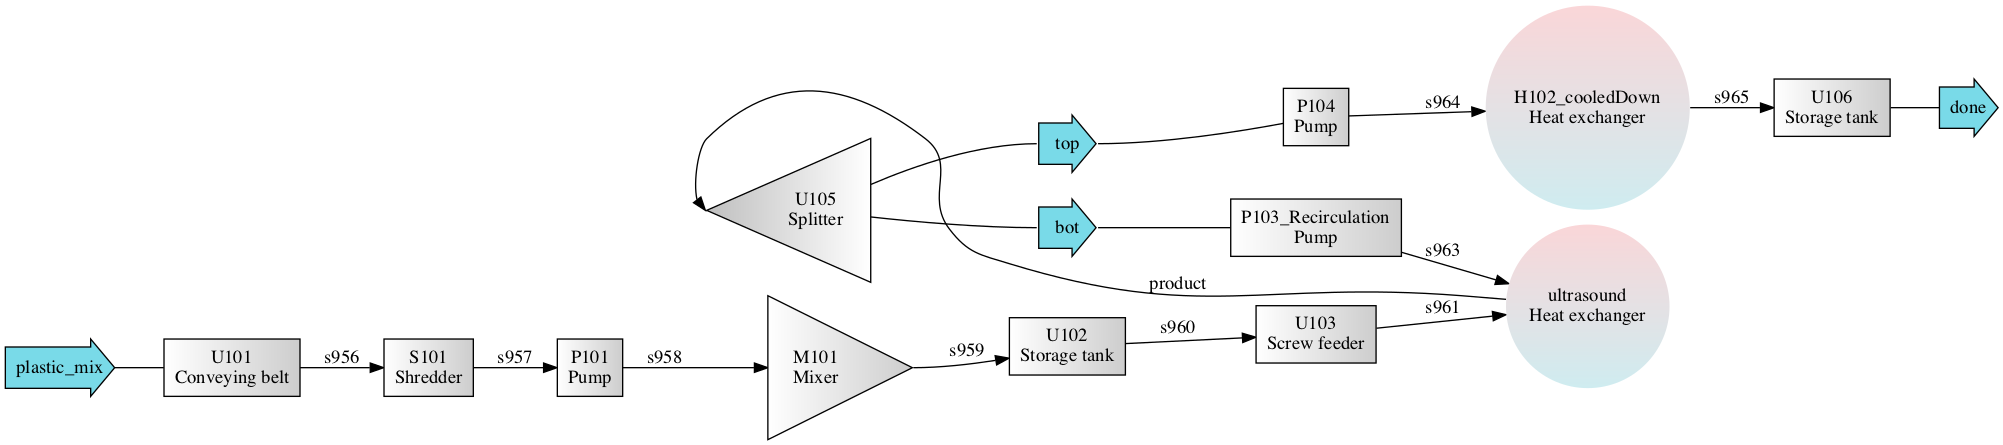

System: polystyrene_reaction_sys
 path: (U101, S101, P101, M101, U102, U103,
        P103_Recirculation, ultrasound,
        U105, P104, H102_cooledDown, U106)


In [692]:
# a la fin de la reaction (before defining facilities)
polystyrene_reaction_sys = bst.main_flowsheet.create_system('polystyrene_reaction_sys')
polystyrene_reaction_sys.diagram('thorough')
polystyrene_reaction_sys.show()

In [585]:
class khepraTEA(bst.TEA):
    
    """
    Create a LipidcaneTEA object for techno-economic analysis of a biorefinery [1]_.

    Parameters
    ----------
    system : System
        Should contain feed and product streams.
    IRR : float
        Internal rate of return (fraction).
    duration : tuple[int, int]
        Start and end year of venture (e.g. (2018, 2038)).
    depreciation : str
        'MACRS' + number of years (e.g. 'MACRS7').
    operating_days : float
        Number of operating days per year.
    income_tax : float
        Combined federal and state income tax rate (fraction).
    lang_factor : float
        Lang factor for getting fixed capital investment from
        total purchase cost. If no lang factor, estimate capital investment
        using bare module factors.
    startup_schedule : tuple[float]
        Startup investment fractions per year
        (e.g. (0.5, 0.5) for 50% capital investment in the first year and 50%
        investment in the second).
    WC_over_FCI : float
        Working capital as a fraction of fixed capital investment.
    labor_cost : float
        Total labor cost (USD/yr).
    fringe_benefits : float
        Cost of fringe benefits as a fraction of labor cost.
    property_tax : float
        Fee as a fraction of fixed capital investment.
    property_insurance : float
        Fee as a fraction of fixed capital investment.
    supplies : float
        Yearly fee as a fraction of labor cost.
    maintenance : float
        Yearly fee as a fraction of fixed capital investment.
    administration : float
        Yearly fee as a fraction of fixed capital investment.

    References
    ----------
    .. [1] Huang, H., Long, S., & Singh, V. (2016). Techno-economic analysis of biodiesel
        and ethanol co-production from lipid-producing sugarcane. Biofuels, Bioproducts
        and Biorefining, 10(3), 299–315. https://doi.org/10.1002/bbb.1640
    """


    def __init__(self, system, IRR, duration, depreciation, income_tax,
                 operating_days, lang_factor, construction_schedule, WC_over_FCI,
                 labor_cost, fringe_benefits, property_tax,
                 property_insurance, supplies, maintenance, administration):
        # Huang et. al. does not take into account financing or startup
        # so these parameters are 0 by default
        super().__init__(system, IRR, duration, depreciation, income_tax,
                         operating_days, lang_factor, construction_schedule,
                         startup_months=0, startup_FOCfrac=0, startup_VOCfrac=0,
                         startup_salesfrac=0, finance_interest=0, finance_years=0,
                         finance_fraction=0, WC_over_FCI=WC_over_FCI)
        self.labor_cost = labor_cost
        self.fringe_benefits = fringe_benefits
        self.property_tax = property_tax
        self.property_insurance = property_insurance
        self.supplies= supplies
        self.maintenance = maintenance
        self.administration = administration

    # The abstract _DPI method should take installed equipment cost
    # and return the direct permanent investment. Huang et. al. assume
    # these values are equal
    def _DPI(self, installed_equipment_cost):
        return installed_equipment_cost

    # The abstract _TDC method should take direct permanent investment
    # and return the total depreciable capital. Huang et. al. assume
    # these values are equal
    def _TDC(self, DPI):
        return DPI

    # The abstract _FCI method should take total depreciable capital
    # and return the fixed capital investment. Again, Huang et. al.
    # assume these values are equal.
    def _FCI(self, TDC):
        return TDC

    # The abstract _FOC method should take fixed capital investment
    # and return the fixed operating cost.
    def _FOC(self, FCI):
        return (FCI*(self.property_tax + self.property_insurance
                     + self.maintenance + self.administration)
                + self.labor_cost*(1+self.fringe_benefits+self.supplies))    

In [591]:
polystyrene_tea = khepraTEA(system=polystyrene_reaction_sys,
                             IRR=0.15,
                             duration=(2018, 2038),
                             depreciation='MACRS7',
                             income_tax=0.35,
                             operating_days=300,
                             lang_factor=3,
                             construction_schedule=(0.4, 0.6),
                             WC_over_FCI=0.05,
                             labor_cost=2.5e6,
                             fringe_benefits=0.4,
                             property_tax=0.001,
                             property_insurance=0.005,
                             supplies=0.20,
                             maintenance=0.01,
                             administration=0.005)

polystyrene_tea.show()
polystyrene_tea.get_cashflow_table()

khepraTEA: polystyrene_reaction_sys
 NPV: -25,037,326 USD at 15.0% IRR


,Depreciable capital,Fixed capital investment,Working capital,Depreciation,Loan,...,Net earnings,Cash flow,Discount factor,Net present value (NPV),Cumulative NPV
2016,0,0,0,0,0,...,0,0,1.15,0,0
2017,0,0,0,0,0,...,0,0,1,0,0
2018,0,0,0,0,0,...,-4e+06,-4e+06,0.87,-3.48e+06,-3.48e+06
2019,0,0,0,0,0,...,-4e+06,-4e+06,0.756,-3.02e+06,-6.5e+06
2020,0,0,0,0,0,...,-4e+06,-4e+06,0.658,-2.63e+06,-9.13e+06
2021,0,0,0,0,0,...,-4e+06,-4e+06,0.572,-2.29e+06,-1.14e+07
2022,0,0,0,0,0,...,-4e+06,-4e+06,0.497,-1.99e+06,-1.34e+07
2023,0,0,0,0,0,...,-4e+06,-4e+06,0.432,-1.73e+06,-1.51e+07
2024,0,0,0,0,0,...,-4e+06,-4e+06,0.376,-1.5e+06,-1.66e+07
2025,0,0,0,0,0,...,-4e+06,-4e+06,0.327,-1.31e+06,-1.79e+07
